# Incoherent noise effects

In [1]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from matplotlib.colors import LogNorm
import matplotlib.cm as cm

%matplotlib inline

In [16]:
N = int(1e5)

Qx = 0.31
Qy = 0.32
SX = np.sin(Qx*2*np.pi)
CX = np.cos(Qx*2*np.pi)
SY= np.sin(Qy*2*np.pi)
CY= np.cos(Qy*2*np.pi)

def rotation(a,b,C,S):
    temp = a
    a = C*a  + S*b
    b = -S*temp + C*b
    return a,b

def noise(NN,DD):
    return np.random.randn(NN)*DD

turns = int(1e3)

In [17]:
D = 1e-4
x = np.random.randn(N)
p = np.random.randn(N)
s = np.random.randn(N)
d = np.random.randn(N)

jx0 = 0.5*(x**2+p**2)
jz0 = 0.5*(s**2+d**2)

for turn in range(turns):
    x,p = rotation(x,p,CX,SX)
    p += noise(N,D)
    
jx = 0.5*(x**2+p**2)
jz = 0.5*(s**2+d**2)


average growth 1.64619893312e-05


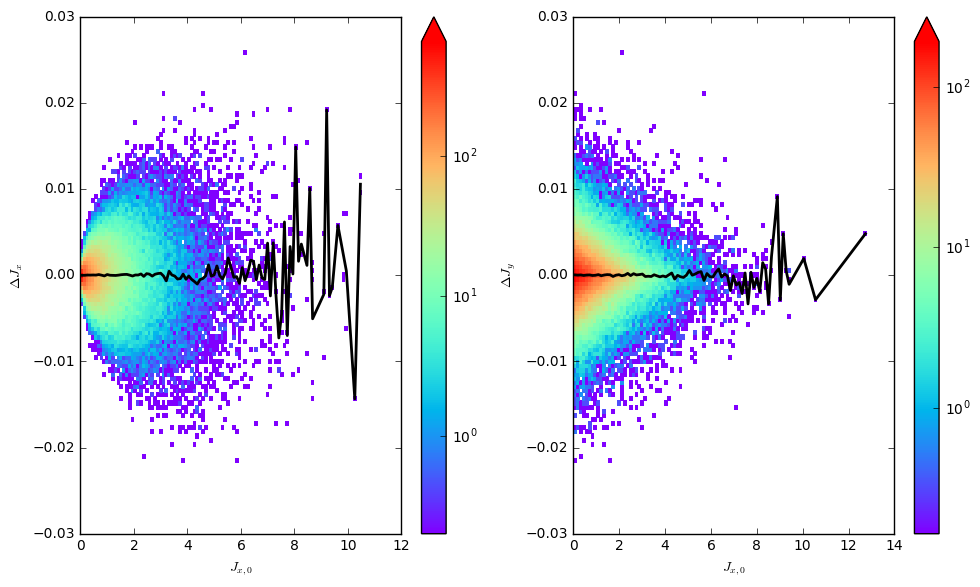

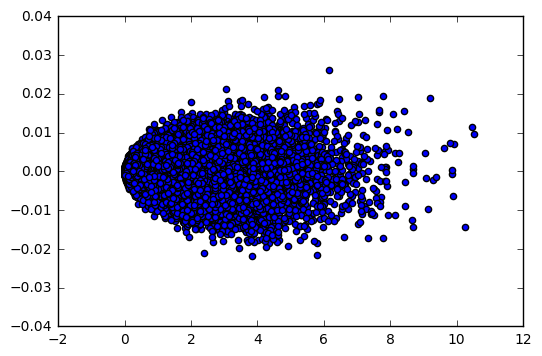

In [18]:
plt.figure(figsize=(10,6))
nbin = 100
XS = [jx0,jz0]
YS = [jx-jx0,jx-jx0]
# XS = [np.sqrt(jx0),np.sqrt(jz0)]
# YS = [jx-jx0,jx-jx0]
for j in range(2):
    ax1 = plt.subplot(121+j)
#     H,xedges,yedges = np.histogram2d(XS[j],YS[j],nbin,range=[[0,np.max(XS[j])],[0,np.max(YS[j])]],normed=True);
    H,xedges,yedges = np.histogram2d(XS[j],YS[j],nbin,range=[[np.min(XS[j]),np.max(XS[j])],[np.min(YS[j]),np.max(YS[j])]],normed=True);
    H = H.transpose()

    vmax = H.max()
    vmin = np.min(H[H>0])

    X,Y = np.meshgrid(xedges, yedges);
    pcm=plt.pcolor(X,Y,H,norm =LogNorm(vmin=vmin,vmax=vmax),cmap='rainbow');
    plt.colorbar(pcm, ax=ax1, extend='max')
    plt.xlabel([r'$J_{x,0}$',r'$J_{y,0}$',r'$J_{z,0}$'][int(j/2)])
    plt.ylabel([r'$\Delta J_x$',r'$\Delta J_y$'][j%2])
    
    ind = np.sum(H,axis=0)>0
    avg = np.average(Y[1:,1:][:,ind],weights=H[:,ind],axis =0)-np.diff(yedges)[0]*0.5
    plt.plot(xedges[1:][ind]-np.diff(xedges)[0]*0.5,avg,'k',lw=2)

plt.tight_layout()


plt.figure()
plt.scatter(jx0,jx-jx0)

print('average growth',np.mean(YS[0]))

In [64]:
# print(X[:,1]) # same value for x
# print(Y[:,1]) # all values for y
print(np.mean(H[:,1]))
print(H.shape,Y.shape)
ind = np.sum(H,axis=0)>0
avg = np.average(Y[1:,1:][:,ind],weights=H[:,ind],axis =0)


12.9461495496
(100, 100) (101, 101)
[  3.15348361e-04   3.15511127e-04   3.30575120e-04   3.12464440e-04
   3.18655421e-04   3.31786168e-04   3.14454640e-04   3.15294549e-04
   3.07680513e-04   3.02847814e-04   2.83961838e-04   3.09505808e-04
   3.16787136e-04   3.15406569e-04   2.88757971e-04   2.98743507e-04
   3.25798257e-04   3.07821008e-04   3.39265597e-04   3.58071333e-04
   3.25016527e-04   3.88599033e-04   3.11159060e-04   3.67974202e-04
   3.38150268e-04   3.10969791e-04   3.25562341e-04   3.33433755e-04
   2.69485630e-04   3.53701044e-04   3.19154532e-04   3.43178417e-04
   1.82579889e-04   3.99371784e-04   1.91493492e-04   2.58704898e-04
   5.29929604e-04   2.93133417e-04   4.29926259e-04   2.85341665e-04
   1.86920826e-04   3.08315428e-04   2.84090731e-04   2.57988764e-04
   2.88468260e-04   4.37065326e-04   5.32295050e-04  -7.90092255e-05
   2.43432557e-04   4.29735826e-04   1.81230920e-04  -4.08706431e-04
   2.44754245e-04  -3.12459305e-05   3.33369405e-04   7.24860981e-0

/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


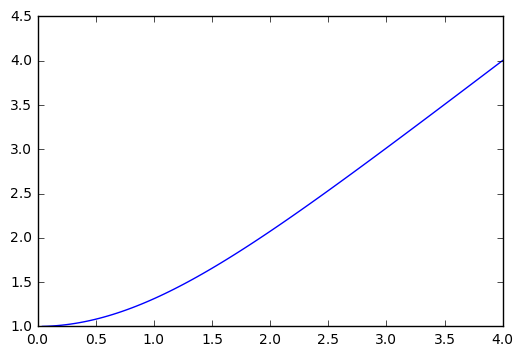

In [19]:
P = np.linspace(0,4,100)
plt.figure()
plt.plot(P,P+2*P/(np.exp(2*P)-1))